# Importations

In [2]:
# from sklearnex import patch_sklearn
# patch_sklearn()

from src.utils import read_split_csv
from src.mlp.mlp import VPowerDataset, train_save
from src.mlp.mlp_plot import plot_learning_curve
from src.mlp.scaling_uncertainty import store_stats, data_normalization
import torch
print("Torch Version", torch.__version__)

Torch Version 1.11.0


In [3]:
torch.cuda.is_available()

True

if not, in shell : 

sudo rmmod nvidia_uvm && sudo modprobe nvidia_uvm

# Load data
(quadricoptere dataset)

In [4]:
datasets = read_split_csv("/App/Data/split_quad/")#, engine="python")
datasets["val"]

val.csv
train.csv


test.csv
lourd.csv


,time_start,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,route,power,power_smoothed
index,,,,,,,,,,,,,,,,,,,,,
109923,2019-07-03 03:10:00,150,35.50,2.8,238.0,22.759777,23.505444,-79.782777,40.458953,365.169441,...,-0.076906,0.335496,-0.143232,-9.869870,12,0,100,R1,534.978656,537.998819
91658,2019-06-29 12:40:00,136,78.60,9.4,4.0,21.084534,26.065914,-79.782571,40.458586,290.375622,...,-0.082310,-1.529684,0.423300,-9.976319,8,250,25,R1,549.587645,526.000169
200354,2019-07-24 16:28:00,229,62.60,10.5,204.0,22.172565,18.448116,-79.782210,40.458218,315.845911,...,0.015051,-1.633767,0.061935,-9.457129,10,0,50,R1,409.042066,432.243997
122937,2019-07-03 16:35:00,162,3.10,0.9,265.0,21.716820,24.189297,-79.782738,40.458992,276.467557,...,-0.054514,0.133585,-0.133318,-10.589297,8,500,75,R1,525.314597,536.179872
164684,2019-07-15 08:05:00,195,112.60,2.2,128.0,23.306925,17.772215,-79.782766,40.459063,367.520864,...,0.018428,0.267958,-0.178819,-8.603159,8,250,100,R1,414.215676,420.793236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119371,2019-07-03 16:10:00,158,4.20,1.0,70.0,22.375399,21.795813,-79.782763,40.458980,270.231115,...,0.012899,0.072653,0.035458,-9.965531,12,250,75,R1,487.689996,544.146733
228319,2019-08-05 18:00:00,252,53.61,2.8,212.0,21.711811,26.304468,-79.781380,40.459499,345.136230,...,-0.000584,-0.393476,0.177744,-9.913366,12,500,75,R1,571.117643,586.617433
255344,2019-10-24 09:45:00,277,72.01,9.0,14.0,21.670494,21.390272,-79.782571,40.458526,293.235121,...,-0.107946,-0.764824,0.548552,-9.283231,10,500,25,R1,463.537766,460.171522


In [5]:
# remove columns 
cols_ignored = ["time_start","battery_voltage","battery_current", "altitude","speed","route", "position_x", "position_y", "flight"]
cols_redundent = ["linear_acceleration_x", "velocity_y", "power"]
target = ["power_smoothed"]

datasets_cleaned = dict()
for k in datasets.keys():
    datasets_cleaned[k] = datasets[k].drop(columns = cols_ignored + cols_redundent) # + target)

datasets_cleaned["val"]

,time,wind_speed,wind_angle,position_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,payload,power_smoothed
index,,,,,,,,,,,,,,,,,
109923,35.50,2.8,238.0,365.169441,0.019652,-0.009543,-0.892996,0.449534,-0.079833,3.000340,0.006295,0.028133,-0.076906,-0.143232,-9.869870,0,537.998819
91658,78.60,9.4,4.0,290.375622,-0.065850,-0.020889,0.102929,0.992287,-0.505729,0.908372,0.071907,0.034870,-0.082310,0.423300,-9.976319,250,526.000169
200354,62.60,10.5,204.0,315.845911,-0.020135,-0.081124,0.972382,0.217915,0.079185,1.620667,-0.015960,0.032285,0.015051,0.061935,-9.457129,0,432.243997
122937,3.10,0.9,265.0,276.467557,-0.029125,-0.007355,-0.769531,0.637903,-0.045260,0.282797,0.178007,0.083491,-0.054514,-0.133318,-10.589297,500,536.179872
164684,112.60,2.2,128.0,367.520864,0.002847,0.011134,0.129321,0.991536,0.140437,-1.149955,-0.005068,0.014159,0.018428,-0.178819,-8.603159,250,420.793236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119371,4.20,1.0,70.0,270.231115,-0.001946,-0.004951,-0.731368,0.681962,0.014317,0.171766,-0.027388,0.043483,0.012899,0.035458,-9.965531,250,544.146733
228319,53.61,2.8,212.0,345.136230,-0.028327,-0.122869,0.967072,0.221073,0.018804,1.762058,-0.044206,0.016506,-0.000584,0.177744,-9.913366,500,586.617433
255344,72.01,9.0,14.0,293.235121,-0.013434,-0.028738,0.109309,0.993502,-0.773985,-0.051941,0.131445,-0.257779,-0.107946,0.548552,-9.283231,500,460.171522


## Data scaling

Data scaling description:
* For the time feature `time` we perform a `zeromax` scaling using the maximum time over training set. 
* The flight number is not scaled
* The rest input features and the target are `standardized` (Z-scaling).

In [6]:
target = "power_smoothed"
input_features = list(datasets_cleaned["train"].columns)
input_features.remove(target)
print(input_features)

# folder to store models and stats
model_dir = "/App/code_preparation/baselines"

['time', 'wind_speed', 'wind_angle', 'position_z', 'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w', 'velocity_x', 'velocity_z', 'angular_x', 'angular_y', 'angular_z', 'linear_acceleration_y', 'linear_acceleration_z', 'payload']


In [7]:
train_data = datasets_cleaned["train"]

# store stats computed on training data so we can use them for inference
means, stds = store_stats(train_data, model_dir)
# time max for max scaling
time_max = train_data.time.max()

In [8]:
data_all_norm = {}
for k in datasets_cleaned.keys():
    data_all_norm[k] = data_normalization(data=datasets_cleaned[k], means=means, stds=stds, time_max=time_max)

In [9]:
train_norm = data_normalization(data=train_data, means=means, stds=stds, time_max=time_max)

dev_in_data = datasets_cleaned["test"]
dev_in_norm = data_normalization(data=dev_in_data, means=means, stds=stds, time_max=time_max)

train_norm

,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,orientation_w,orientation_x,orientation_y,orientation_z,payload,position_z,power_smoothed,velocity_x,velocity_z,wind_angle,wind_speed,time
index,,,,,,,,,,,,,,,,,
73245,0.655824,0.184456,-0.171442,0.333621,-4.967999,-0.880669,0.454052,0.229560,1.352152,0.007379,-1.346699,1.937011,0.561537,1.466609,0.990661,-0.880284,0.023432
16830,-0.035753,0.355712,-0.733666,1.984459,-0.154424,1.217911,-0.305529,-0.346488,0.159482,0.007379,-0.715804,0.138210,-1.024095,0.062553,2.582314,0.180172,0.442286
256306,1.364210,-0.172487,0.223178,-0.261906,0.527392,-1.034703,-0.635105,-2.314157,1.357951,1.221184,0.882617,1.563948,-0.931588,2.395572,1.687598,2.153799,0.179128
92785,-0.362237,0.290305,-0.719936,3.129304,1.658736,1.174823,-2.023530,-1.110646,0.226805,0.007379,1.767828,0.175483,0.576308,1.276056,2.883692,1.859228,0.349676
58106,0.224665,-0.375548,-0.120677,-0.895484,1.199466,-1.654210,0.603554,0.395324,-1.319698,-1.206427,-1.175607,0.635170,-0.609908,1.146379,1.094260,-0.320598,0.029560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86435,-0.041423,-0.038187,0.478742,1.055518,-0.185559,1.156269,-2.241585,-0.771591,0.277924,1.221184,0.130878,0.323648,-0.093198,1.162061,2.940201,2.006513,0.300288
257631,-0.409300,0.265893,-0.422280,0.583397,0.415668,1.227503,0.757584,0.283303,0.105737,-1.206427,-0.884261,-0.529817,0.318283,-0.728865,1.951304,-0.615170,0.350757
101588,-1.069225,0.185275,-0.708103,0.499390,0.429168,1.196028,-1.189949,-0.679506,0.213055,1.221184,0.163840,-0.452858,-0.443822,0.747192,-0.290195,1.122800,0.299603


In [10]:
train_norm.shape

(139006, 17)

In [11]:
train_ds = VPowerDataset(data=train_norm,
                         input_features=input_features,
                         target=target)
val_ds = VPowerDataset(data=dev_in_norm,
                       input_features=input_features,
                       target=target)
                       
train_ds.norm_df.describe()

,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,orientation_w,orientation_x,orientation_y,orientation_z,payload,position_z,power_smoothed,velocity_x,velocity_z,wind_angle,wind_speed,time
count,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,139006.000000,1.390060e+05,139006.000000
mean,-8.996412e-18,2.351335e-18,-9.507572e-18,-1.302691e-16,-2.743744e-13,1.230208e-15,2.074286e-16,3.354230e-16,-1.335405e-17,8.505698e-17,-1.418450e-12,6.534155e-14,-7.906619e-16,4.610661e-16,1.197446,-5.784795e-16,0.279733
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.175498
min,-1.705390e+01,-1.827931e+01,-6.416585e+00,-8.249302e+00,-2.480568e+01,-1.755655e+00,-5.366546e+00,-5.284002e+00,-1.320697e+00,-1.206427e+00,-1.725689e+00,-5.691864e+00,-1.274268e+01,-2.632926e+00,-0.431466,-1.587254e+00,0.000000
25%,-4.833157e-01,-2.983924e-01,-3.574760e-01,-5.172347e-01,-3.308623e-01,-1.030616e+00,-3.681116e-01,-4.028865e-01,-8.575250e-01,-1.206427e+00,-7.838318e-01,-4.592195e-01,-3.999875e-01,-7.787637e-01,0.246634,-8.213693e-01,0.133742
50%,2.342631e-03,3.006872e-03,-1.164961e-01,-3.419829e-02,2.269205e-02,3.325118e-01,1.520386e-01,1.106615e-01,1.319233e-01,7.378572e-03,-3.517995e-02,2.676728e-02,1.807705e-01,-7.043224e-02,1.357966,-2.322271e-01,0.267844
75%,4.892355e-01,3.123176e-01,1.431176e-01,4.816354e-01,4.055403e-01,8.399744e-01,4.524366e-01,4.559519e-01,1.339351e+00,1.221184e+00,8.824814e-01,5.298406e-01,4.367156e-01,6.232662e-01,1.951304,6.514862e-01,0.406273
max,1.978503e+01,1.409486e+01,7.400811e+00,9.916518e+00,9.470536e+00,1.231334e+00,8.115451e+00,5.816320e+00,1.412163e+00,1.221184e+00,1.947681e+00,3.859987e+00,2.442699e+01,3.252586e+00,2.949619,3.715026e+00,1.000000


# Model training
Trains a certain number of models with the same architecture but there will be different initilizations. Saves them in *model_dir*. 

In [ ]:
# device = "cpu"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device :", device)
imin = 1
imax = 20

models_hs = train_save(imin, imax, model_dir, device, train_ds, val_ds, input_features, n_epochs=25)

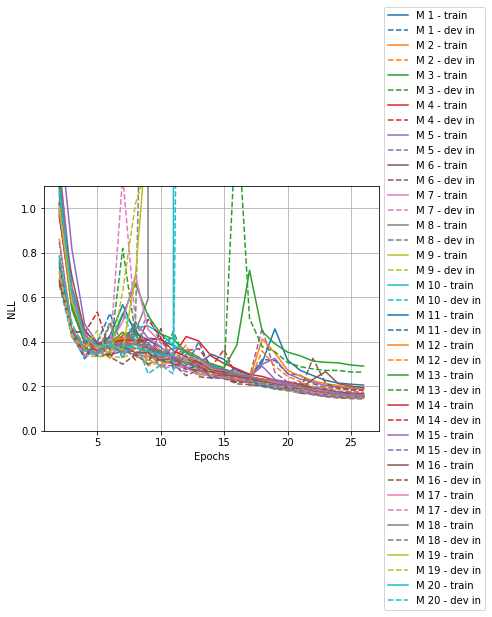

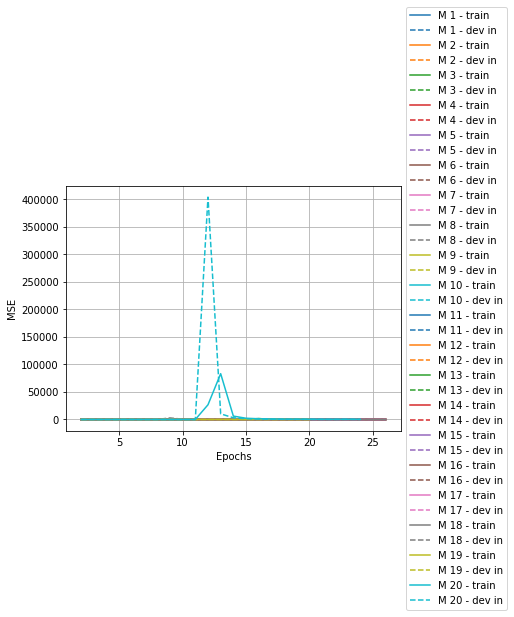

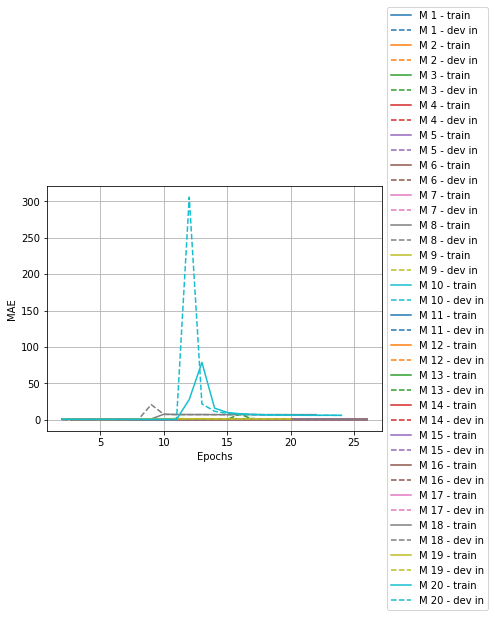

In [ ]:
plot_learning_curve(history=models_hs,
                    metric="loss",
                    label="NLL",
                    ylims=(0.0, 1.1)
                    )
plot_learning_curve(history=models_hs,
                    metric="mse",
                    label="MSE",
                    # ylims=(0.01, 0.2)
                    )
plot_learning_curve(history=models_hs,
                    metric="mae",
                    label="MAE",
                    # ylims=(0.1, 0.35)
                    )